In [1]:
import cmasher as cmr
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
import numpy as np
import pyccl as ccl
print(ccl.__version__)

3.0.0


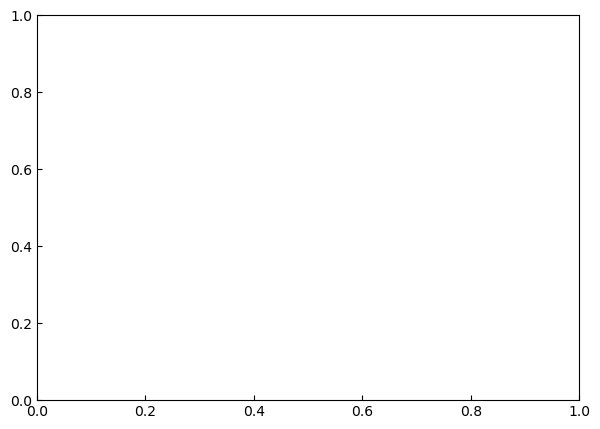

In [2]:
# Set default rcParams using plt.rc
plt.rc('figure', figsize=[7, 5])  # Default figure size
plt.rc('lines', linewidth=3, markersize=10)  # Default line width and marker size
plt.rc('image', cmap='cmr.pride')  # Default color map
plt.gca().tick_params(direction='in', which='both')  # Tick parameters for both xtick and ytick
plt.rc('axes', labelsize=15)  # Font sizes for x and y labels
plt.rc('legend', frameon=False, fontsize=12)  # Legend properties

# Default colors
def get_colors(data_len, cmap='cmr.pride'):
    return cmr.take_cmap_colors(cmap, data_len, cmap_range=(0.1, 0.9), return_fmt='hex')
# Use "plasma" colormap as well
plots_path = "plots_output/"

In [3]:
cosmology_vanilla = ccl.CosmologyVanillaLCDM()  # cosmology object
k = np.logspace(-3, 1, 100)  # wavenumber
a = 1.  # scale factor a z=0
# Compute the nonlinear power spectra, no baryons
# note that this is using halofit
pk_nonlin = ccl.nonlin_matter_power(cosmology_vanilla, k, a)

# Construct the Power Spectra

## DM only $P_k$ 

In [4]:
# Dark matter only $P_K$ from the Mira-Titan emulator
emulator_dm_only = ccl.CosmicemuMTIVPk("tot")  # nonlinear power spectrum emulator for CosmicEmu (Mira-Titan IV)
cosmology_dm_only = ccl.CosmologyVanillaLCDM(matter_power_spectrum=emulator_dm_only)  # cosmology object
pk_dm_only = cosmology_dm_only.nonlin_matter_power(k, a)

##  HMCode $P_k$

In [5]:
cosmology_hmcode = ccl.CosmologyVanillaLCDM(
   matter_power_spectrum="camb",
   extra_parameters={"camb": {"kmax": 20.0,
                               "halofit_version": "mead2020_feedback",
                               "HMCode_logT_AGN": 7.8}}
)
pk_hmcode = cosmology_hmcode.nonlin_matter_power(k, a)

## BCM $P_k$

In [6]:
bcm = ccl.baryons.BaryonsSchneider15()  # baryonic correction model
bcm_boost = bcm.include_baryonic_effects(
    cosmo=cosmology_vanilla,
    pk=cosmology_vanilla.get_nonlin_power()
)
pk_bcm = bcm_boost(k, a)

## BACCOEmu $P_k$

In [7]:
baccoemu = ccl.BaccoemuBaryons()
cosmology_baccoemu = ccl.CosmologyVanillaLCDM()
bacco_boost = baccoemu.boost_factor(cosmology_baccoemu, k, a)
pk_bacco = cosmology_baccoemu.nonlin_matter_power(k, a) * bacco_boost

2024-01-25 14:51:37.395797: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## VanDaalen $P_k$

In [8]:
vd = ccl.baryons.BaryonsvanDaalen19()  # Van Daalen 2019
vd_boost = vd.include_baryonic_effects(
   cosmo=cosmology_vanilla,
    pk=cosmology_vanilla.get_nonlin_power()
)
pk_vd = vd_boost(k, a)

In [11]:
# Here we save the data to a npy file

# First we define the data dictionary
data_dict = {
    "k": k,
    "pk_nonlin": pk_nonlin,
    "pk_dm_only": pk_dm_only,
    "pk_bcm": pk_bcm,
    "pk_vd": pk_vd,
    "pk_hmcode": pk_hmcode,
    "pk_bacco": pk_bacco,
}

# Define a separate dictionary for labels
labels_dict = {
    "k": "$k$",
    "pk_nonlin": "$P(k)^\mathrm{nonlin}$",
    "pk_dm_only": "$P(k)^\mathrm{DM \; only}$",
    "pk_bcm": "$P(k)^\mathrm{Schneider 15}$",
    "pk_vd": "$P(k)^\mathrm{Van Daalen 19}$",
    "pk_hmcode": "$P(k)^\mathrm{Mead 20}$",
    "pk_bacco": "$P(k)^\mathrm{Aricò 21}$",
}

# Then we save the data dictionary to a npy file
np.save("data/baryons_pk_data.npy", data_dict)
np.save("data/baryons_pk_labels.npy", labels_dict)

# We load the data from the npy file
data_dict = np.load("data/baryons_pk_data.npy", allow_pickle=True).item()

# Plot the Power Spectra

In [10]:
# List of pk data and their labels
labels = [
    "$P(k)^\mathrm{DM \; only}$",
    "$P(k)^\mathrm{Mead 20}$",
    "$P(k)^\mathrm{Schneider 15}$",
    "$P(k)^\mathrm{Aricò 21}$",
    "$P(k)^\mathrm{Van Daalen 19}$"
]
# Take 5 colors from rainforest in [0.15, 0.85] range in HEX
data_len = len(pk_data)
colors = get_colors(data_len)
lw=3

# Set the figure size
plt.figure(figsize=(7, 5))
# Add the reference line for pk_nonlin / pk_nonlin = 1
plt.semilogx(k, [1]*len(k), c="darkgray", lw=2)  # Using darkgray color for the reference line

# Loop over the pk data and colors to plot them
for (pk, label), color in zip(pk_data, colors):
    plt.semilogx(k, pk, c=color, label=label, lw=lw)

# Setting the properties for ticks, labels, and legend
plt.gca().tick_params(direction='in', which='both')  
plt.xlabel("$k \: \: \mathrm{[Mpc^{-1}]}$", fontsize=15)
plt.ylabel("$F (k)$", fontsize=15)

# Change y-axis labels to standard notation
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

plt.legend(frameon=False, fontsize=15)
plt.show()

NameError: name 'pk_data' is not defined